[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<Figure size 432x288 with 0 Axes>

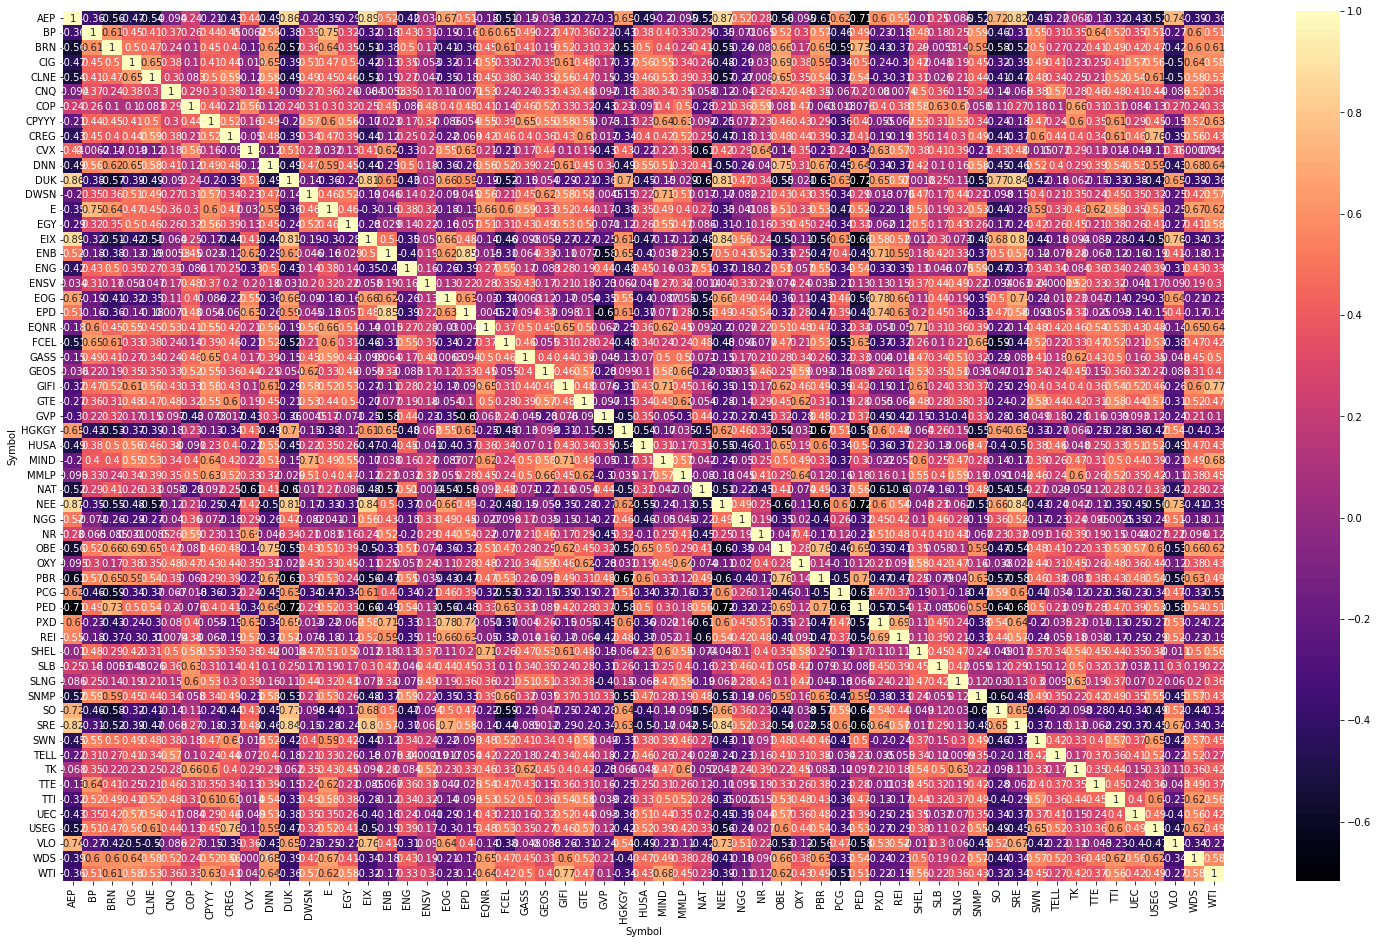

<Figure size 432x288 with 0 Axes>

In [ ]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
from datetime import datetime
# To visualize the results
import matplotlib.pyplot as plt
import seaborn
yf.pdr_override()

tickers = [
    "SO", "EOG", "CNQ", "EPD", "OXY", "E", "VLO",
    "SRE", "PXD", "NGG", "AEP", "WDS", "COP", "BP",
    "EQNR", "ENB", "DUK", "SLB", "PBR",
    "PCG", "EIX", "CVX", "SHEL", "TTE", "NEE",
    'SNMP', 'MIND', 'ENG', 'GTE', 'GVP',
    'ENSV', 'PED', 'DNN', 'DWSN', 'TELL',
    'CREG', 'CIG', 'REI', 'USEG', 'BRN', 'MMLP',
    'GASS', 'HUSA', 'FCEL', 'NAT', 'UEC', 'TTI',
    'GIFI', 'SLNG', 'NR', 'EGY',
    'SWN', 'CPYYY', 'TK', 'HGKGY', 'GEOS', 'WTI',
     'CLNE' ,'OBE'
    ]

#clean data and check for untradable stocks
dfs = []
invalids = []
for ticker in tickers:
  data = pdr.get_data_yahoo(ticker, start="2007-12-31", end="2017-12-31")
  data["Symbol"] = ticker
  if data.isnull().values.any():
    invalids.append(ticker)
  else:
    dfs.append(data)

print(invalids)
dataframe = dfs.copy()

#restructure dataframe
df = pd.concat(dfs)
df = df.reset_index()
df = df[["Date", "Close", "Symbol"]]
df_pivot = df.pivot('Date','Symbol','Close').reset_index()

#perform kendall correlation test
corr_df = df_pivot.corr(method='kendall')
corr_df.reset_index()
stacked = corr_df.rename_axis(None).rename_axis(None, axis = 1)
stacked = stacked.stack().reset_index()
stacked = stacked.sort_values(0)

non_self = stacked[stacked[0] != 1]
non_self = non_self.rename(columns={'level_0':'Stock 1', 'level_1':'Stock 2', 0: "Kendall Corr"})
non_self_dup = non_self[-1::-2]
print(non_self_dup.head(20))

plt.figure(figsize=(26, 16))
seaborn.heatmap(corr_df, annot=True, cmap= "magma")
plt.figure()






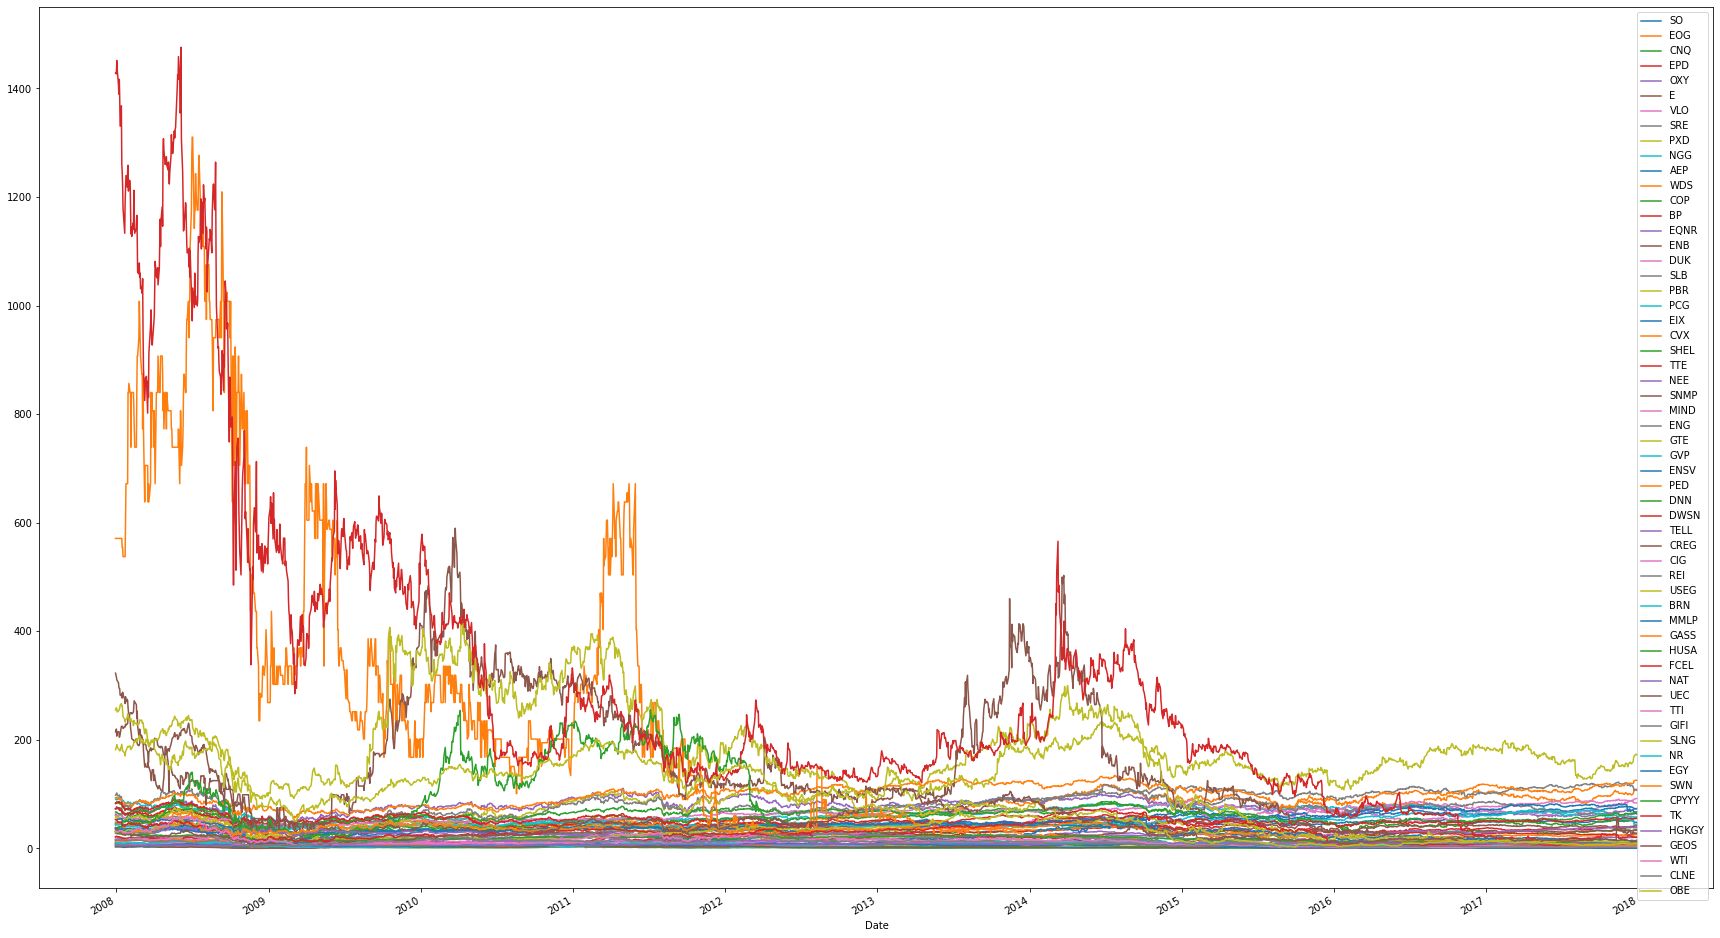

In [ ]:
# create consolidated dataframe and plot

for df in dataframe:
  df = df.reset_index()
  df["Date"] = pd.to_datetime(df["Date"])

consolidated = pd.DataFrame()
for df in dataframe:
  consolidated[df["Symbol"][0]] = df["Close"]

consolidated.plot(figsize=(30, 18))




In [ ]:
#Ad Fuller Test and Correlation/Cointegration Filter
from sklearn import linear_model
import statsmodels.api as sm
import numpy as np

#function to find cointegration
def cointegration(x,y):
  regr = linear_model.LinearRegression()
  x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
  regr.fit(x_constant, y)
  beta = regr.coef_[0]
  alpha = regr.intercept_
  spread = y - x*beta - alpha
  adf = sm.tsa.stattools.adfuller(spread, autolag='AIC')
  return adf[1]

for i in range(consolidated.shape[1]):
  # print("here")
  if consolidated.iloc[:,i].isnull().values.any():
    print (consolidated.columns[i])

c1 = non_self_dup['Stock 1'][:200]
c2 = non_self_dup['Stock 2'][:200]

p_values = []

c_chart = pd.DataFrame()
c_chart['Stock 1'] = c1
c_chart['Stock 2'] = c2

for i in range(c1.shape[0]):
  column_1 = consolidated[c1.iloc[i]]
  column_2 = consolidated[c2.iloc[i]]
  coint_val = cointegration(column_1,column_2)
  p_values.append(coint_val)

c_chart['p_value'] = p_values
c_chart = c_chart.reset_index()
c_chart = c_chart.sort_values('p_value')
c_chart = c_chart[c_chart['p_value'] <= .05]
print(c_chart)

compare_cols = ['Stock 1','Stock 2']
mask = pd.Series(list(zip(*[non_self[c] for c in compare_cols]))).isin(list(zip(*[c_chart[c] for c in compare_cols])))

mask_list = mask.tolist()
corr_coint = non_self[mask_list]

corr_coint = corr_coint[corr_coint.iloc[:,2] > .7]
print(corr_coint.tail())

#Filtering stocks based on Cointegration AD Fuller test and Kendall Correlation test

#Want to find stocks above 95% correlation that we can confidently say are cointegrated (p value <= .05)










/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

     index Stock 1 Stock 2       p_value
180   3409     WDS    SNMP  7.545178e-11
22    2362     PED     BRN  1.541351e-07
153    105      BP    SNMP  7.447220e-06
141   2716    SNMP     BRN  1.228464e-05
54     181     CIG    CLNE  2.860954e-05
..     ...     ...     ...           ...
70    1297    EQNR     WTI  4.563830e-02
77     443   CPYYY    MIND  4.842842e-02
128   1693   HGKGY     PXD  4.895649e-02
32    2164     OBE     PED  4.974953e-02
196   3185     TTI     WTI  4.995188e-02

[107 rows x 4 columns]
     Stock 1 Stock 2  Kendall Corr
527     CREG    USEG      0.757777
1533    GIFI     WTI      0.765297
697      DUK     SRE      0.842294
964      ENB     EPD      0.847367
1947     NEE     AEP      0.870079


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
def run_strategy(data, lookback, width, stock1, stock2, s1_pos, s2_pos):
  #calculating our 63-day hedge ratio lookback window like this makes our program more flexible and readable
  hr_lookback_months = 3
  monthly_trading_days = 21
  hr_lookback = monthly_trading_days * hr_lookback_months

  #these are our familiar hedge ratio and spread calculations
  df = data.copy()
  df['hedge_ratio'] = df[stock1].rolling(hr_lookback).corr(df[stock2]) * df[stock1].rolling(hr_lookback).std() / df[stock2].rolling(hr_lookback).std()
  df['spread'] = df[stock1] - df['hedge_ratio'] * df[stock2]

  #BB calculations
  df['rolling_spread'] = df['spread'].rolling(lookback).mean() #lookback-day SMA of spread
  df['rolling_spread_std'] = df['spread'].rolling(lookback).std() #lookback-day rolling STD of spread
  df['rolling_z_score'] = (df['spread'] - df['rolling_spread'])

  df['upper_band'] = df['rolling_spread'] + (width * df['rolling_spread_std']) #upper = SMA + width * STD
  df['lower_band'] = df['rolling_spread'] - (width * df['rolling_spread_std']) #lower = SMA - width * STD



  s1_pnl = f'P&L {stock1}'
  s2_pnl = f'P&L {stock2}'

  df[s1_pos] = 0
  df[s2_pos] = 0
  df[s1_pnl] = 0
  df[s2_pnl] = 0


  # S1 = df.loc[:,stock1]
  # S2 = df.loc[:,stock2]
  # ratios = df['hedge_ratio']

  money = 0
  countS1 = 0
  countS2 = 0
  signal = False
  trades = 0
  c1_pos = 0
  c2_pos = 0
  c_hedge = 0
  trade = False
  trades = 0
  p1 = 0
  p2 = 0


  for date, row in df.iterrows():
    # Sell short if the z-score is > 1
    trade = False
    if row['rolling_z_score'] > width:
      if not signal:
        c1_pos = -1
        c_hedge = row['hedge_ratio']
        c2_pos = -c1_pos * c_hedge
        df.loc[date,s1_pos] = c1_pos
        df.loc[date,s2_pos] = c2_pos
        p1 = row[stock1]
        p2 = row[stock2]
        signal = True
        trade = True
      else: #there was a signal (assuming same as before)
        df.loc[date,s1_pos] = c1_pos
        df.loc[date,s2_pos] = c2_pos
    # Buy long if the z-score is < 1
    elif row['rolling_z_score'] < -width:
      if not signal:
        c1_pos = 1
        c_hedge = row['hedge_ratio']
        c2_pos = -c1_pos * c_hedge
        df.loc[date,s1_pos] = c1_pos
        df.loc[date,s2_pos] = c2_pos
        p1 = row[stock1]
        p2 = row[stock2]
        signal = True
        trade = True
      else: #there was a signal (assuming same as before)
        df.loc[date,s1_pos] = c1_pos
        df.loc[date,s2_pos] = c2_pos
    # Clear positions if the z-score between -.5 and .5
    if abs(row['rolling_z_score']) < (width+1)/4 or abs(row['rolling_z_score']) > width * 1.5:
      if signal:
        c1_pos = -c1_pos
        c2_pos = -c2_pos
        df.loc[date,s1_pos] = 0
        df.loc[date,s2_pos] = 0
        signal = False
        trade = True

    if trade:
      trades +=1
      # row[s1_pnl] = c1_pos * row[stock1]
      # row[s2_pnl] = c2_pos * row[stock2]
      # c1_pnl = c1_pos * row[stock1]
      # c2_pnl = c1_pos * row[stock2]
      df.loc[date,s1_pnl] = c1_pos * (row[stock1] - p1)
      df.loc[date,s2_pnl] = c2_pos * (row[stock2] - p2)


      # print (row[s2_pnl])
#       print('Z-score: '+ str(df['rolling_z_score'][i]), countS1, countS2, S1[i] , S2[i])
  #How to determine prices and loses. PnL only occurs when trade is made, trade is made
  df['P&L'] = df[s1_pnl] + df[s2_pnl]
  # print (df[s1_pnl].value_counts())
  return df


In [ ]:
stock1 = 'NEE'
stock2 = 'AEP'
s1_pos = f'Position {stock1}'
s2_pos = f'Position {stock2}'

standard_BB_train_df = run_strategy(consolidated, 42, 2.236, stock1, stock2, s1_pos, s2_pos) #20-day and 2 STD are the standard BB parameters used
standard_BB_train_df['P&L'].value_counts()
standard_BB_train_df['P&L'].sum()
# standard_BB_train_df['P&L'].value_counts()

0.3239638322461489

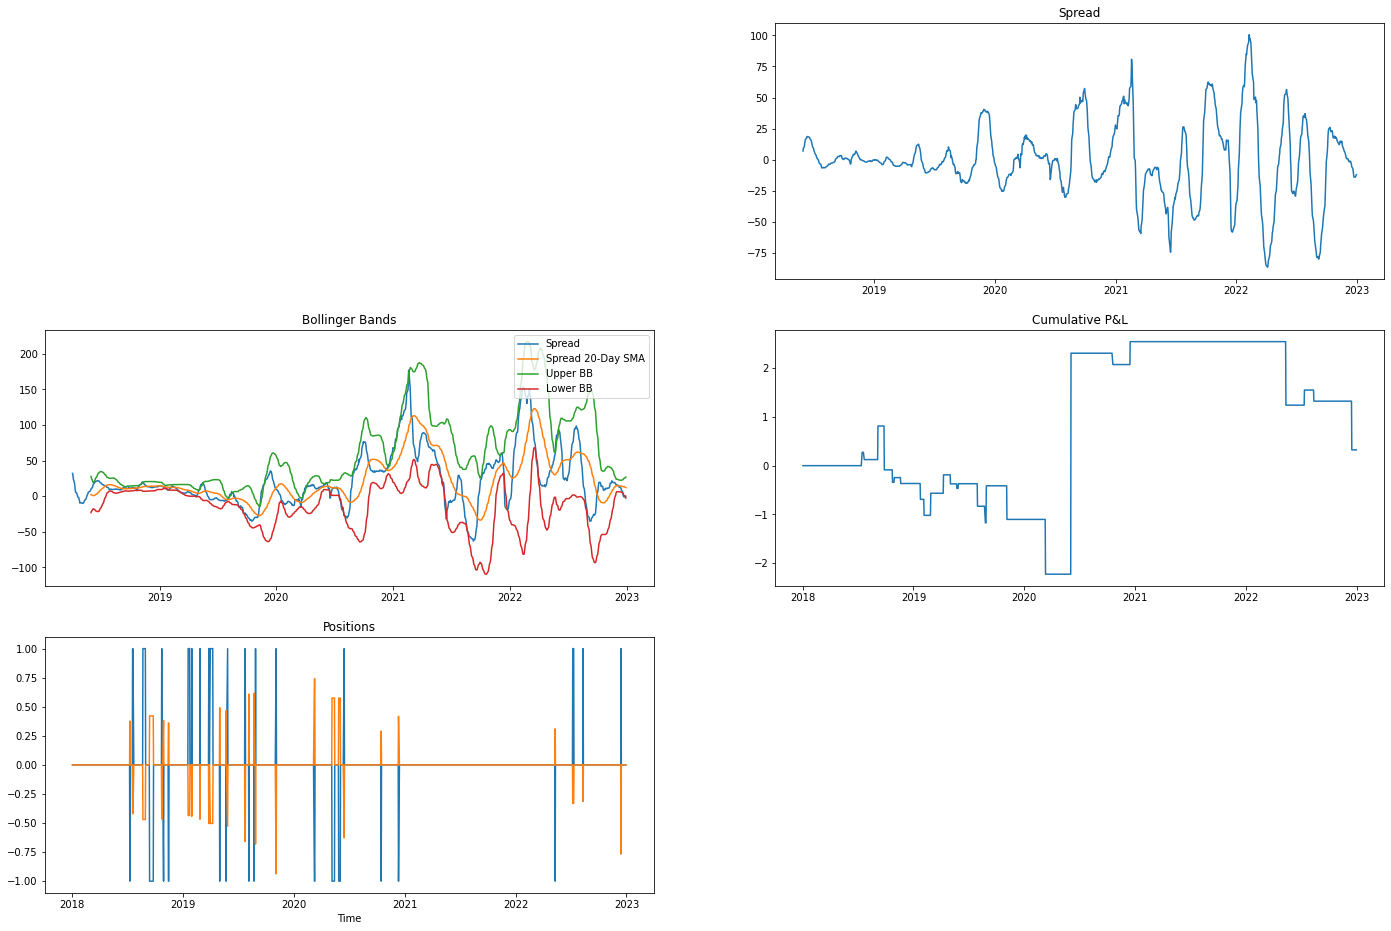

In [ ]:

#plot intermediate and final results of using these parameters on training data
fig = plt.figure(figsize=(24,16)) #overall plot size
# ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

# ax1.plot(standard_BB_train_df['hedge_ratio'])
# ax1.set_title("Hedge Ratio")

ax2.plot(standard_BB_train_df['rolling_z_score'])
ax2.set_title("Spread")

ax3.plot(standard_BB_train_df['spread'], label = 'Spread')
ax3.plot(standard_BB_train_df['rolling_spread'], label = 'Spread 20-Day SMA')
ax3.plot(standard_BB_train_df['upper_band'], label = 'Upper BB')
ax3.plot(standard_BB_train_df['lower_band'], label = 'Lower BB')
ax3.set_title("Bollinger Bands")
ax3.legend(loc="upper right")



ax4.plot(standard_BB_train_df['P&L'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax4.set_title("Cumulative P&L")

ax5.plot(standard_BB_train_df[f'Position {stock1}'], label = "GLD")
ax5.plot(standard_BB_train_df[f'Position {stock2}'], label = "GDXJ")
ax5.set_title("Positions")

plt.xlabel("Time")
plt.show()

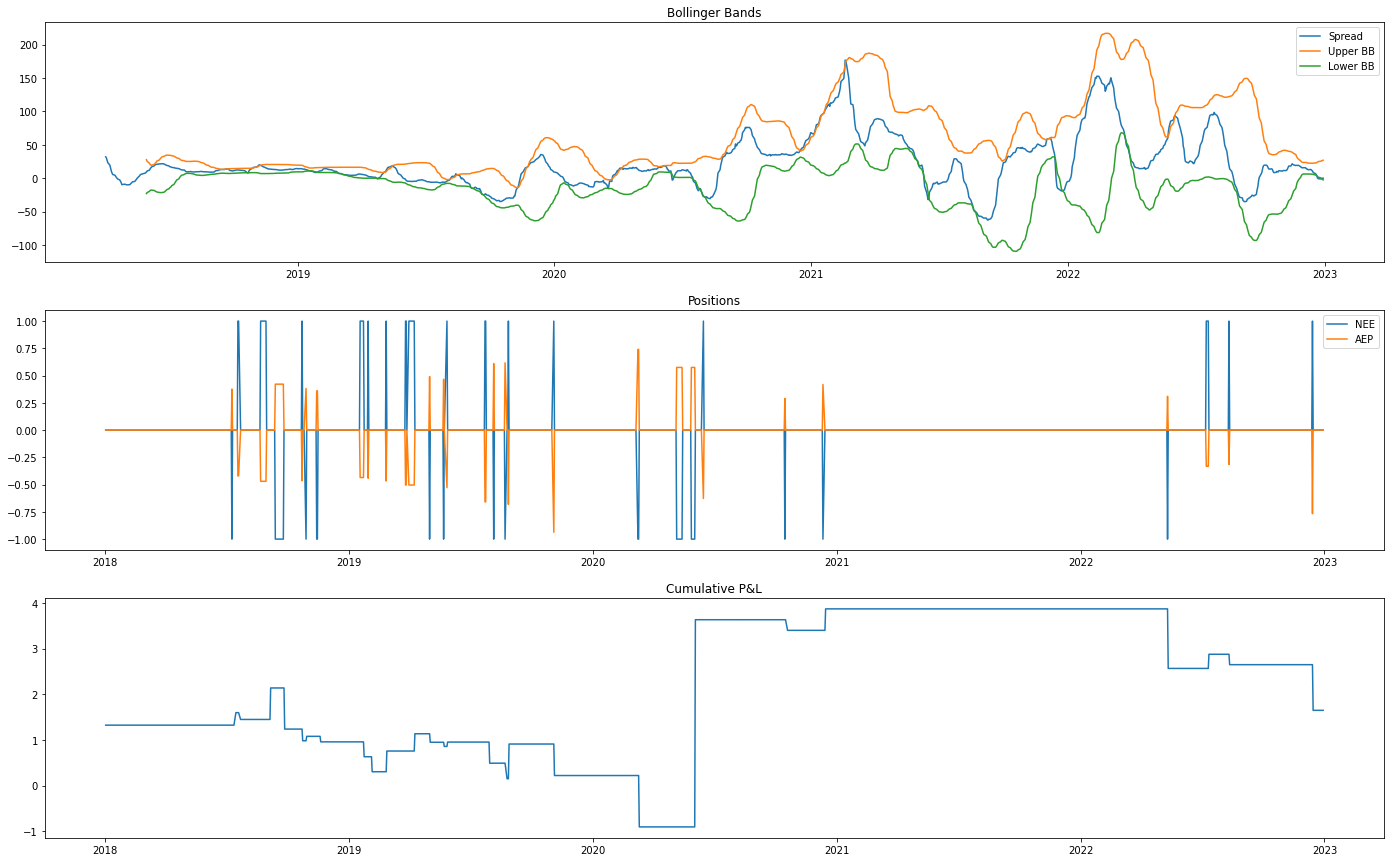

In [ ]:
last_fifty = standard_BB_train_df.iloc[:]
fig = plt.figure(figsize=(24,15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(last_fifty['spread'], label = 'Spread')
ax1.plot(last_fifty['upper_band'], label = 'Upper BB')
ax1.plot(last_fifty['lower_band'], label = 'Lower BB')
ax1.set_title("Bollinger Bands")
ax1.legend(loc="upper right")

ax2.plot(last_fifty[s1_pos], label = stock1)
ax2.plot(last_fifty[s2_pos], label = stock2)
ax2.set_title("Positions")
ax2.legend(loc="upper right")

ax3.plot(standard_BB_train_df['P&L'].cumsum().iloc[-20] + last_fifty['P&L'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax3.set_title("Cumulative P&L")

plt.show()

In [ ]:
# A function for calculating Sharpe Ratio.
# Takes: a Pandas Series, and an optional risk free rate percentage

def get_sharpe(r,rfr=0.02):
  if r.std():
    return (r.mean()) / r.std() * np.sqrt(252)
    # return (r.mean() - rfr) / r.std()
  return 0

In [ ]:
print('Sharpe ratio:', get_sharpe(standard_BB_train_df['P&L']))


#Run for loop, finding sharpe and maximizing

stock1 = 'NEE'
stock2 = 'AEP'
s1_pos = f'Position {stock1}'
s2_pos = f'Position {stock2}'










# sharpe_list = []
# # for i in range (45,50):
# for j in range (25,30):
#   st_d = j/10
#   standard_BB_train_df = run_strategy(consolidated, 30, st_d, stock1, stock2, s1_pos, s2_pos) #20-day and 2 STD are the standard BB parameters used
#   ans = get_sharpe(standard_BB_train_df['P&L'])
#   sharpe_list.append((30,st_d,ans))



# def Sort_Tuple(tup):

#     # getting length of list of tuples
#     lst = len(tup)
#     for i in range(0, lst):
#         for j in range(0, lst-i-1):
#             if (tup[j][2] > tup[j + 1][2]):
#                 temp = tup[j]
#                 tup[j] = tup[j + 1]
#                 tup[j + 1] = temp
#     return tup


# Driver Code

# print (sharpe_list)
# for i in sharpe_list:
#   print (i)



Sharpe ratio: 0.4680485080366767


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklea

     index Stock 1 Stock 2   p_value
121   1601     GVP    CREG  0.000003
189   1306    FCEL    CREG  0.000004
55    2241     OXY     WTI  0.000009
188   2212     OXY    HUSA  0.000011
193   3263    USEG    ENSV  0.000015
..     ...     ...     ...       ...
179   3061      TK     TTE  0.045294
149   1958     NEE     DUK  0.047422
51    1842    MMLP       E  0.048491
33     696     DUK      SO  0.048608
133   1193     EPD       E  0.049419

[91 rows x 4 columns]
     Stock 1 Stock 2  Kendall Corr
3112     TTE     SLB      0.798429
94        BP      NR      0.813038
1280    EQNR     PXD      0.823821
802        E      NR      0.832678
336      CNQ     PXD      0.833873


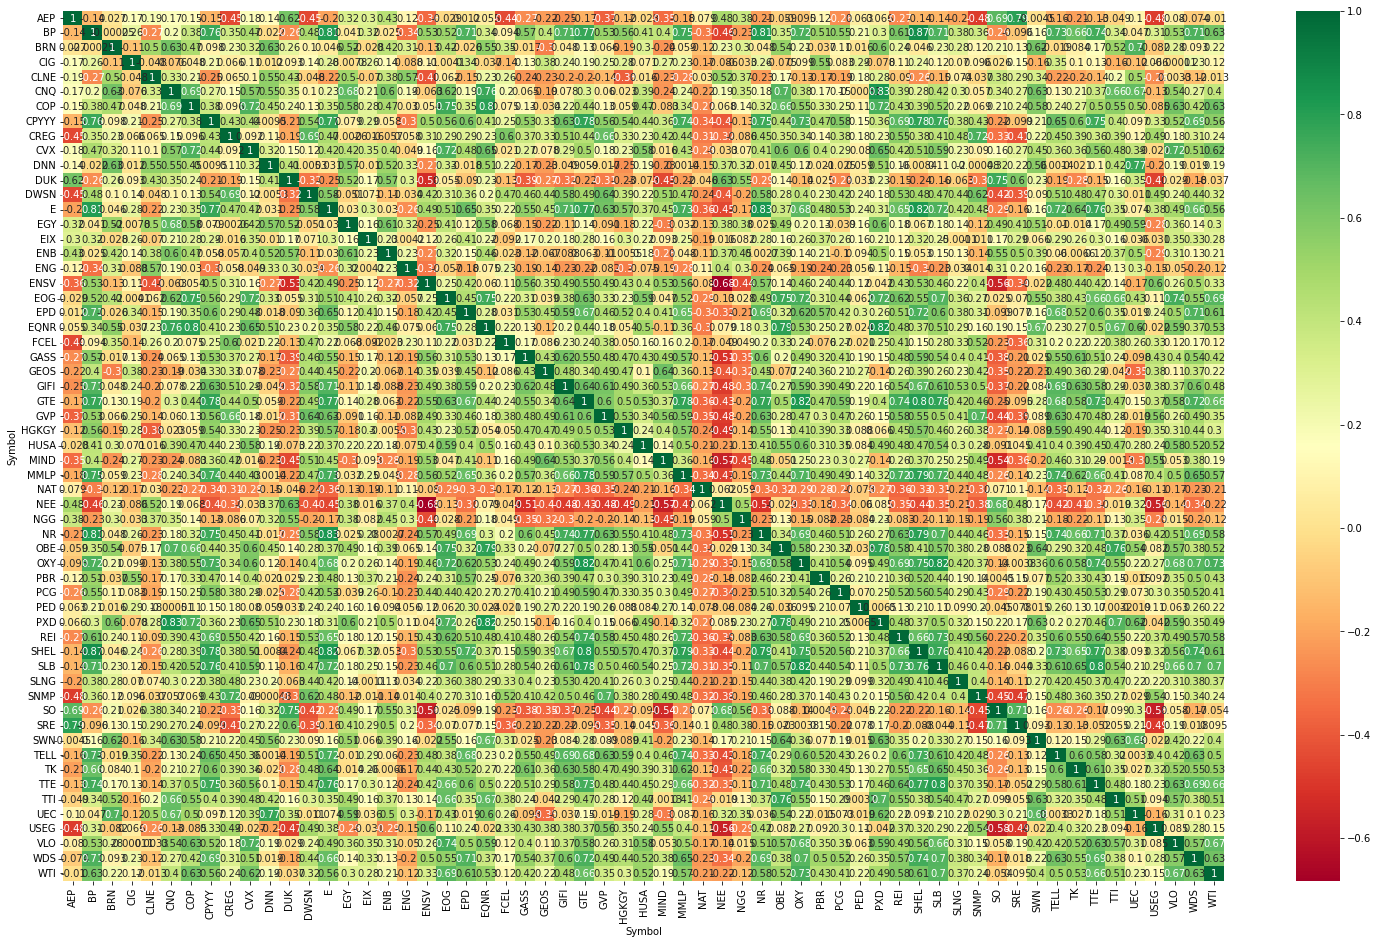

<Figure size 432x288 with 0 Axes>

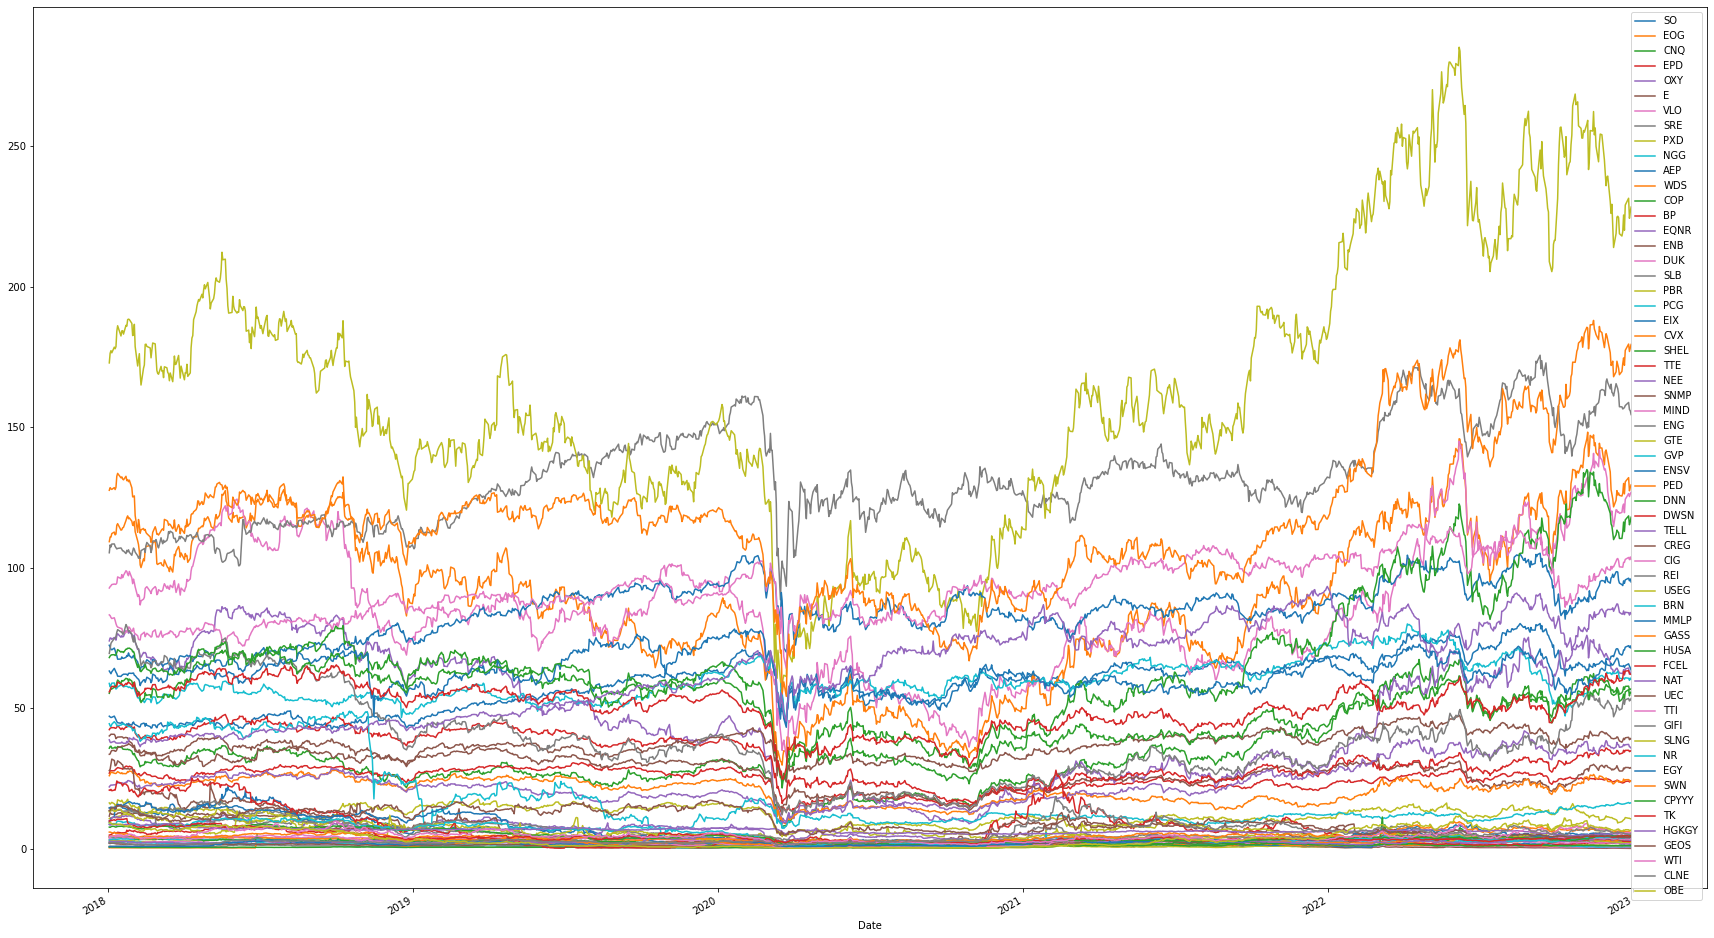

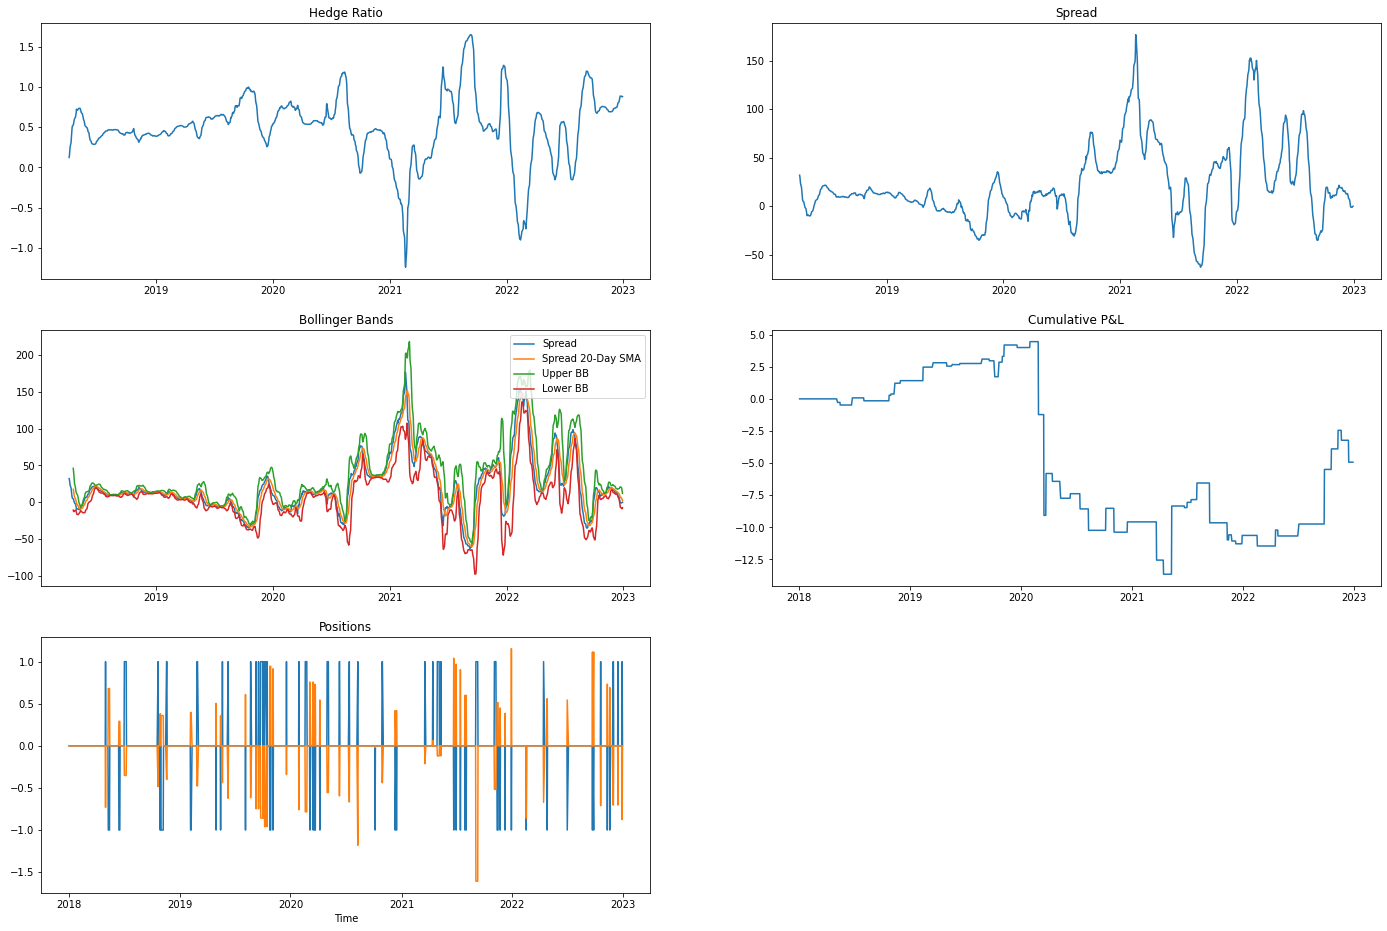

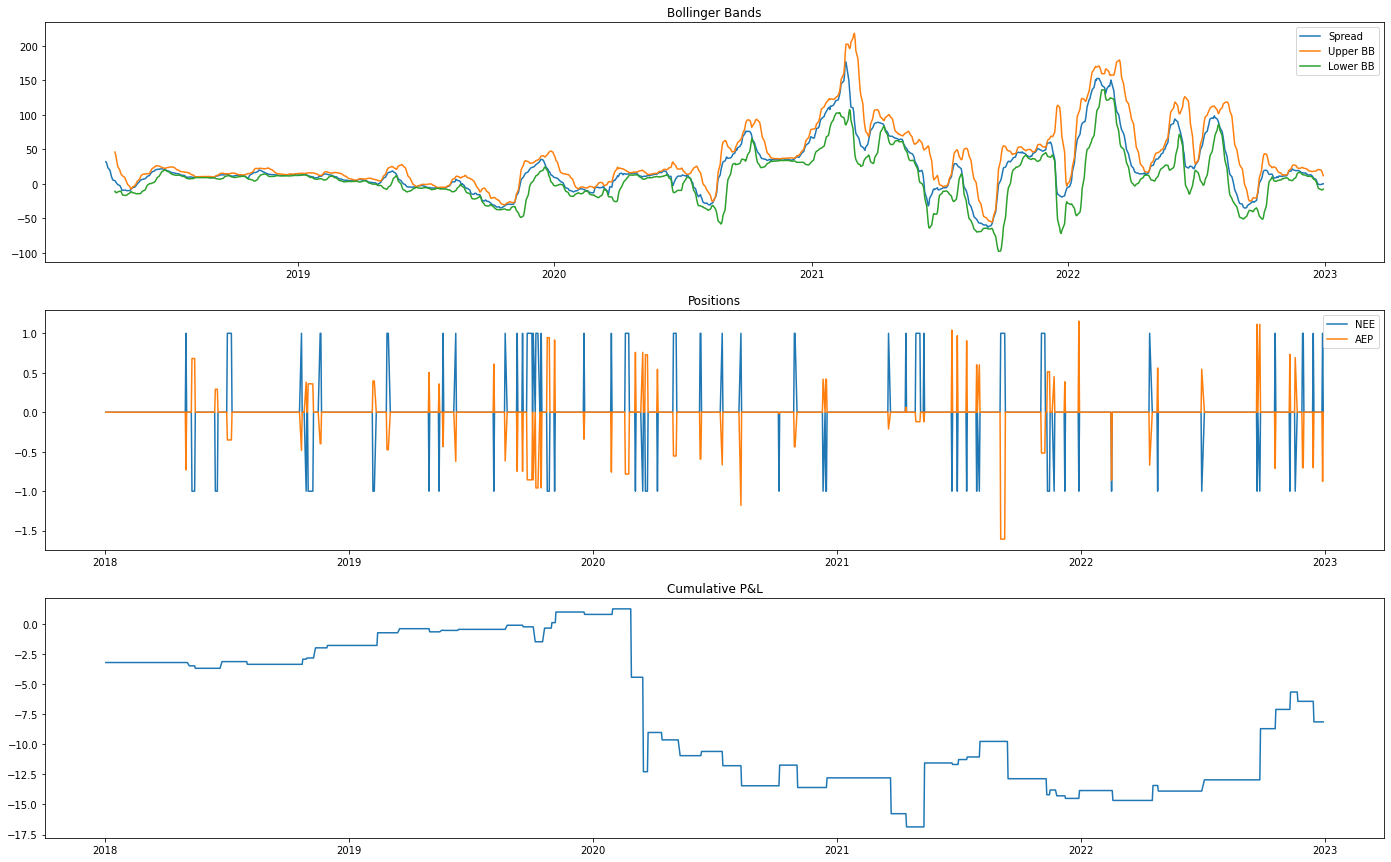

In [ ]:
###TESTING
tickers = [
    "SO", "EOG", "CNQ", "EPD", "OXY", "E", "VLO",
    "SRE", "PXD", "NGG", "AEP", "WDS", "COP", "BP",
    "EQNR", "ENB", "DUK", "SLB", "PBR",
    "PCG", "EIX", "CVX", "SHEL", "TTE", "NEE",
    'SNMP', 'MIND', 'ENG', 'GTE', 'GVP',
    'ENSV', 'PED', 'DNN', 'DWSN', 'TELL',
    'CREG', 'CIG', 'REI', 'USEG', 'BRN', 'MMLP',
    'GASS', 'HUSA', 'FCEL', 'NAT', 'UEC', 'TTI',
    'GIFI', 'SLNG', 'NR', 'EGY',
    'SWN', 'CPYYY', 'TK', 'HGKGY', 'GEOS', 'WTI',
     'CLNE' ,'OBE'
    ]

#clean data and check for untradable stocks
dfs = []
invalids = []
for ticker in tickers:
  data = pdr.get_data_yahoo(ticker, start="2017-12-31", end="2022-12-31")
  data["Symbol"] = ticker
  if data.isnull().values.any():
    invalids.append(ticker)
  else:
    dfs.append(data)

print(invalids)
dataframe = dfs.copy()

#restructure dataframe
df = pd.concat(dfs)
df = df.reset_index()
df = df[["Date", "Close", "Symbol"]]
df_pivot = df.pivot('Date','Symbol','Close').reset_index()

#perform kendall correlation test
corr_df = df_pivot.corr(method='kendall')
corr_df.reset_index()
stacked = corr_df.rename_axis(None).rename_axis(None, axis = 1)
stacked = stacked.stack().reset_index()
stacked = stacked.sort_values(0)

non_self = stacked[stacked[0] != 1]
non_self = non_self.rename(columns={'level_0':'Stock 1', 'level_1':'Stock 2', 0: "Kendall Corr"})
non_self_dup = non_self[-1::-2]
print(non_self_dup.head(20))

plt.figure(figsize=(26, 16))
seaborn.heatmap(corr_df, annot=True, cmap= "RdYlGn")
plt.figure()


for df in dataframe:
  df = df.reset_index()
  df["Date"] = pd.to_datetime(df["Date"])

consolidated = pd.DataFrame()
for df in dataframe:
  consolidated[df["Symbol"][0]] = df["Close"]

consolidated.plot(figsize=(30, 18))

#function to find cointegration
def cointegration(x,y):
  regr = linear_model.LinearRegression()
  x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
  regr.fit(x_constant, y)
  beta = regr.coef_[0]
  alpha = regr.intercept_
  spread = y - x*beta - alpha
  adf = sm.tsa.stattools.adfuller(spread, autolag='AIC')
  return adf[1]

for i in range(consolidated.shape[1]):
  # print("here")
  if consolidated.iloc[:,i].isnull().values.any():
    print (consolidated.columns[i])

c1 = non_self_dup['Stock 1'][:200]
c2 = non_self_dup['Stock 2'][:200]

p_values = []

c_chart = pd.DataFrame()
c_chart['Stock 1'] = c1
c_chart['Stock 2'] = c2

for i in range(c1.shape[0]):
  column_1 = consolidated[c1.iloc[i]]
  column_2 = consolidated[c2.iloc[i]]
  coint_val = cointegration(column_1,column_2)
  p_values.append(coint_val)

c_chart['p_value'] = p_values
c_chart = c_chart.reset_index()
c_chart = c_chart.sort_values('p_value')
c_chart = c_chart[c_chart['p_value'] <= .05]
print(c_chart)

compare_cols = ['Stock 1','Stock 2']
mask = pd.Series(list(zip(*[non_self[c] for c in compare_cols]))).isin(list(zip(*[c_chart[c] for c in compare_cols])))

mask_list = mask.tolist()
corr_coint = non_self[mask_list]

corr_coint = corr_coint[corr_coint.iloc[:,2] > .7]
print(corr_coint.tail())

#Filtering stocks based on Cointegration AD Fuller test and Kendall Correlation test

#Want to find stocks above 95% correlation that we can confidently say are cointegrated (p value <= .05)

stock1 = 'NEE'
stock2 = 'AEP'
s1_pos = f'Position {stock1}'
s2_pos = f'Position {stock2}'

standard_BB_train_df = run_strategy(consolidated, 10, 2.75, stock1, stock2, s1_pos, s2_pos) #20-day and 2 STD are the standard BB parameters used
standard_BB_train_df['P&L'].value_counts()
standard_BB_train_df['P&L'].sum()
# standard_BB_train_df['P&L'].value_counts()


#plot intermediate and final results of using these parameters on training data
fig = plt.figure(figsize=(24,16)) #overall plot size
ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)

ax1.plot(standard_BB_train_df['hedge_ratio'])
ax1.set_title("Hedge Ratio")

ax2.plot(standard_BB_train_df['spread'])
ax2.set_title("Spread")

ax3.plot(standard_BB_train_df['spread'], label = 'Spread')
ax3.plot(standard_BB_train_df['rolling_spread'], label = 'Spread 20-Day SMA')
ax3.plot(standard_BB_train_df['upper_band'], label = 'Upper BB')
ax3.plot(standard_BB_train_df['lower_band'], label = 'Lower BB')
ax3.set_title("Bollinger Bands")
ax3.legend(loc="upper right")


ax4.plot(standard_BB_train_df['P&L'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax4.set_title("Cumulative P&L")

ax5.plot(standard_BB_train_df[f'Position {stock1}'], label = "GLD")
ax5.plot(standard_BB_train_df[f'Position {stock2}'], label = "GDXJ")
ax5.set_title("Positions")

plt.xlabel("Time")
plt.show()


last_fifty = standard_BB_train_df.iloc[:]
fig = plt.figure(figsize=(24,15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(last_fifty['spread'], label = 'Spread')
ax1.plot(last_fifty['upper_band'], label = 'Upper BB')
ax1.plot(last_fifty['lower_band'], label = 'Lower BB')
ax1.set_title("Bollinger Bands")
ax1.legend(loc="upper right")

ax2.plot(last_fifty[s1_pos], label = stock1)
ax2.plot(last_fifty[s2_pos], label = stock2)
ax2.set_title("Positions")
ax2.legend(loc="upper right")

ax3.plot(standard_BB_train_df['P&L'].cumsum().iloc[-20] + last_fifty['P&L'].cumsum()) #note: we use cumsum here to see *cumulative* profit
ax3.set_title("Cumulative P&L")

plt.show()

